## 4. 신경망 시작하기 : 분류와 회귀

-- 진행

- 영화 리뷰를 긍정 또는 부정으로 분류하기 (이진분류)
- 신문 기사를 토픽으로 분류하기 (다중분류)
- 부동산 데이터를 바탕으로 주택가격을 예측하기 (스칼라 회귀)

-- 용어 정의

- 샘플/입력 : 모델의 주입될 하나의 데이터 포인트
- 예측/출력 : 모델로부터 나오는 값
- 타깃 : 정답, 외부 데이터 소스에 근거하여 예측해야하는 값
- 예측 오차/ 손실 값 : 예측과 타깃 사이의 거리를 측정한 값
- 클래스 ; 분류 문제에서 선택할 수 있는 가능한 레이블의 집합
- 참 값(ground-truth)/annotation : 데이터셋에 대한 모든 타깃 (사람이 수집)
- 이진 분류 : 각 입력 샘플이 2개의 배타적인 범주로 구분되는 분류
- 다중 분류 : 각 입력 샘플이 2개 이상의 범주로 구분되는 분류작업
- 다중 레이블 분류 : 각 입력 샘플이 여러 개의 레이블에 할당 될 수 있는 분류 작업
  > e.g. 한 사진에 강아지와 고양이가 함께 있을 경우 '강아지','고양이' 레이블에 모두 할당
- 스칼라 회귀 : 타깃이 연속적인 스칼라 값인 작업, 각기 다른 타깃과 연속적인 공간을 형성
- 벡터 회귀 : 타깃이 연속적인 값의 집합인 작업,
  > e.g. 이미지의 bounding box 좌표
- 미니 배치/배치 : 모델에 의해 동시에 처리되는 소량의 샘플 묶음, GPU 할당이 용의하도록 2의 거듭제곱으로 하는 경우가 많음



## 4.1 영화 리뷰 분류 : 이진 분류 문제


**데이터셋**

IMDB(Internet Movie Database):

양극단의 리뷰 5 만여개가 50:50으로 분포되어있음

 keras에 포함되어있는 데이터 셋

In [1]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000)
# num_words = N: 잦은 빈도의 단어 최상위 N 개 사용
# 제한 하지 않는 경우 불필요하게 많은 고유 단어들이 포함됨

17464789/17464789 [==============================] - 0s 0us/step


In [2]:
train_data[0][:20] # 단어의 인덱스 리스트 (단어 시퀀스가 인코딩 되어있는 데이터)

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25]

In [3]:
train_labels[0] # 1 : 부정, 0 : 긍정

1

In [4]:
max([max(seq) for seq in train_data])

9999

In [5]:
word_index = imdb.get_word_index() # 단어-정수가 매칭된 dict 객체 호출
reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])
decoded_review = " ".join([reverse_word_index.get(i-3,'?') for i in train_data[0]])
'''
index 0,1,2는
'패딩', '문서 시작', '사전에 없음'
을 위해 예약 되어 있어 3개를 제외하고 시작함
'''
decoded_review

1641221/1641221 [==============================] - 0s 0us/step


"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### 4.1.2 데이터 준비

- `list to tensor 1`
1. 같은 길이가 되도록 리스트에 padding 추가
2. (samples, max_lenght) 크기의 정수 텐서로 변환
3. LSTM 과 같은 rnn 계열의 layer 연결

- `list to tensor 2`
1. 10000개 단어에 대해 multi-hot encoding으로 0과 1의 벡터 변환
2. 부동 소수점 벡터 데이터를 다룰 수 있는 Dense layer 연결


In [38]:
import seaborn as sns

In [6]:
import numpy as np
# list to tensor 2
def vectorize_sequences(seqs, dimension = 10000):
  results = np.zeros((len(seqs),dimension)) # (samples, dimension) 사이즈의 0 행렬 생성
  for i, seq in enumerate(seqs):
    for j in seq:
      results[i,j] = 1. # 특정 인덱스의 위치를 1로 지정
  return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [7]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [8]:
y_train = np.asarray(train_labels).astype(np.float32)
y_test = np.asarray(test_labels).astype(np.float32)

### 4.1.3 신경망 모델 만들기

4장 Dense 조건
- 2 Dense layer with 16 units each
- 1 Dense to predict scalar



In [9]:
x_train.shape

(25000, 10000)

In [40]:
from tensorflow import keras
from tensorflow.keras import layers

def Model():
  seq = keras.Input(shape = (x_train.shape[1],))
  x = layers.Dense(16, activation = 'relu')(seq)
  x = layers.Dense(16, activation = 'relu')(x)
  x = layers.Dense(1, activation = 'sigmoid')(x)
  return  keras.Model(inputs= seq, outputs = x)

model = Model()

In [41]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

### 4.1.4 훈련 검증

validation data lenght = 10000

In [42]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

x_val.shape, x_train.shape

((10000, 10000), (25000, 10000))

In [43]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs =20,
                    batch_size = 512,
                    validation_data = [x_val, y_val])

Epoch 1/20
30/30 [==============================] - 2s 57ms/step - loss: 0.5202 - accuracy: 0.7737 - val_loss: 0.3842 - val_accuracy: 0.8651
Epoch 2/20
30/30 [==============================] - 1s 36ms/step - loss: 0.3106 - accuracy: 0.8951 - val_loss: 0.3168 - val_accuracy: 0.8771
Epoch 3/20
30/30 [==============================] - 1s 38ms/step - loss: 0.2316 - accuracy: 0.9218 - val_loss: 0.2904 - val_accuracy: 0.8830
Epoch 4/20
30/30 [==============================] - 1s 34ms/step - loss: 0.1914 - accuracy: 0.9361 - val_loss: 0.2755 - val_accuracy: 0.8883
Epoch 5/20
30/30 [==============================] - 1s 35ms/step - loss: 0.1565 - accuracy: 0.9502 - val_loss: 0.3009 - val_accuracy: 0.8792
Epoch 6/20
30/30 [==============================] - 1s 34ms/step - loss: 0.1344 - accuracy: 0.9571 - val_loss: 0.3133 - val_accuracy: 0.8797
Epoch 7/20
30/30 [==============================] - 1s 48ms/step - loss: 0.1176 - accuracy: 0.9626 - val_loss: 0.2966 - val_accuracy: 0.8829
Epoch 8/20
30

간단한 모델로 cpu 사용해도 오래 걸리지 않음
validation_data 가 포함된 경우 학습이 끝나고 validation data에 대한 손실과 정확도를 검사하기 때문에 조금 더 지연됨

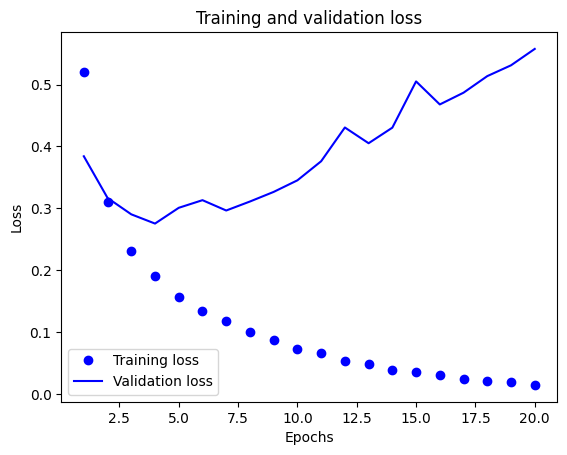

In [44]:
import matplotlib.pyplot as plt

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

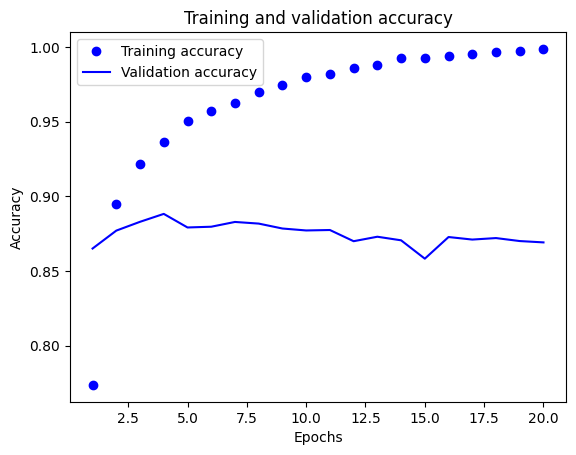

In [45]:
plt.clf()

acc = history.history['accuracy']
val_acc= history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [46]:
def show_log(history):
  loss_values = history.history['loss']
  val_loss_values = history.history['val_loss']

  epochs = range(1, len(loss_values)+1)

  f, (ax1,ax2) = plt.subplots(1,2,figsize = (10,5))
  ax1.plot(epochs, loss_values, 'bo', label = 'Training loss')
  ax1.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
  ax1.set_title('Training and validation loss')
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend()

  acc = history.history['accuracy']
  val_acc= history.history['val_accuracy']

  ax2.plot(epochs, acc, 'bo', label = 'Training accuracy')
  ax2.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
  ax2.set_title('Training and validation accuracy')
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Accuracy")
  ax2.legend()

  plt.show()


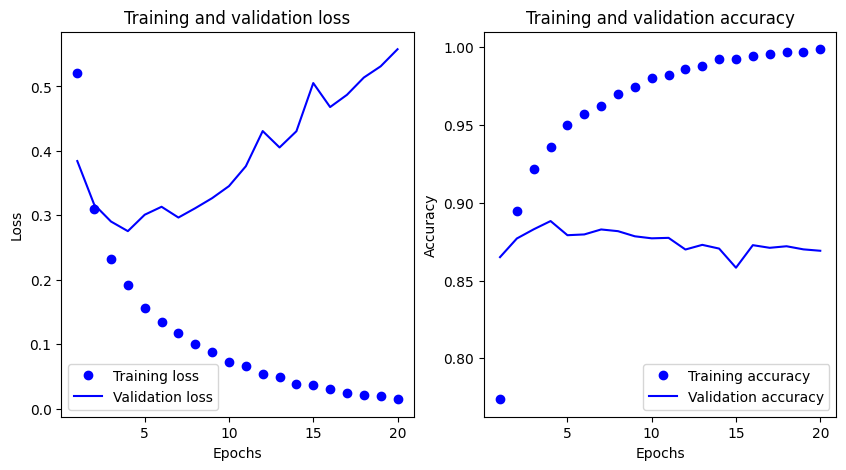

In [47]:
show_log(history)

검증 손실과 정확도가 학습 데이터의 것과는 다른 양상을 보임

손실 그래프는 역전되는 경향을 보이며, 정확도는 떨어지고 있음
-> 모델이 처음 보는 데이터에는 제대로 작동하지 않음

`과대적합(overfitting)`

In [48]:
model = Model()
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs = 4,
          batch_size = 512,
          validation_data = [x_val, y_val])

Epoch 1/4
30/30 [==============================] - 2s 55ms/step - loss: 0.5044 - accuracy: 0.7820 - val_loss: 0.3744 - val_accuracy: 0.8658
Epoch 2/4
30/30 [==============================] - 1s 33ms/step - loss: 0.3031 - accuracy: 0.8963 - val_loss: 0.3049 - val_accuracy: 0.8875
Epoch 3/4
30/30 [==============================] - 1s 34ms/step - loss: 0.2277 - accuracy: 0.9230 - val_loss: 0.2805 - val_accuracy: 0.8871
Epoch 4/4
30/30 [==============================] - 1s 34ms/step - loss: 0.1816 - accuracy: 0.9379 - val_loss: 0.3122 - val_accuracy: 0.8745


```
The first argument to `Layer.call` must always be passed.
```

에러가 발생했었음, 함수 이름을 model()로 지정했기 때문에 변수와 함수명이 헷갈려서 call 관련 부분에서 에러가 생긴 것으로 판단되어 Model()로 개명

In [49]:
results = model.evaluate(x_test, y_test)
# loss 0.3328, accuracy 0.8624

782/782 [==============================] - 3s 3ms/step - loss: 0.3328 - accuracy: 0.8624


### 4.1.5 훈련된 모델로 새로운 데이터에 대해 예측하기

predict를 사용하면 각 리뷰에 대한 애매하게 분포되어있음

In [50]:
prob = model.predict(x_test)

782/782 [==============================] - 2s 2ms/step


In [51]:
prob = [x[0] for x in prob]

In [52]:
prob_0 = [x for x,y in zip(prob,y_test) if y == 0]
prob_1 = [x for x,y in zip(prob,y_test) if y == 1]

In [53]:
import pandas as pd

df0 = pd.DataFrame({'prob': prob_0,
                    'label': [0]* len(prob_0)})

df1 = pd.DataFrame({'prob': prob_1,
                    'label': [1]* len(prob_1)})

df = pd.concat([df0,df1])
del df1, df0

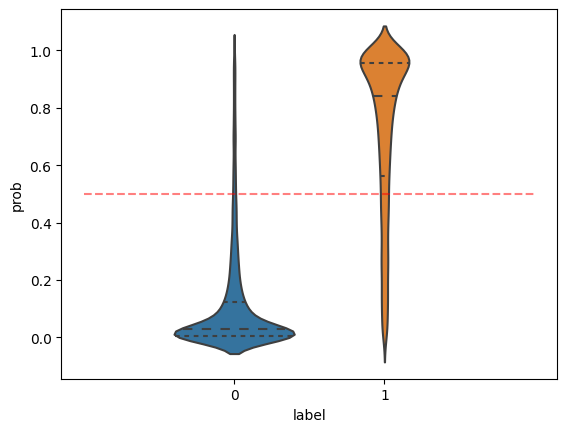

In [54]:
import seaborn as sns

sns.violinplot(df, x = 'label', y = 'prob',
               inner = 'quartiles',
               alpha = 0.5, saturation = 0.7)
plt.plot(list(range(-1, 3)), [0.5]*len(list(range(-1, 3))), 'r--', alpha = 0.5)
plt.show()

### 4.1.6 추가 실험

  1. 분류층 1~3개 사용 별 성능 변화
  2. 층의 유닛 추가 및 감소 (32, 64)
  3. binary_crossentropy 대신 mse 사용
  4. relu -> tanh 사용

## 4.2 뉴스 기사 분류 : 다중 분류 문제

leuter 기사를 46개의 상호 배타적인 토픽으로 분류하는 다중 분류 문제 (단일 레이블 다중 분류)

### 4.2.1 로이터 데이터셋

1986년 로이터 공개 뉴스기사와 토픽의 집합, 로이터 데이터 셋

- 토픽 별 데이터 개수가 상이함
- 토픽 별 최소 10개 이상의 데이터가 존재함

In [55]:
from tensorflow.keras.datasets import reuters

(train_data,train_labels), (test_data,test_labels)=reuters.load_data( num_words=10000)

In [56]:
len(train_data), [len(x) for x in train_data[:10]]

(8982, [87, 56, 139, 224, 101, 116, 100, 100, 82, 106])

In [57]:
topic = pd.DataFrame(pd.Series(train_labels).value_counts().sort_index()).reset_index()
topic = topic.rename(columns = {0:'Counts',
                                'index': 'Topic'})

In [58]:
topic.head()

,Topic,Counts
0,0,55
1,1,432
2,2,74
3,3,3159
4,4,1949


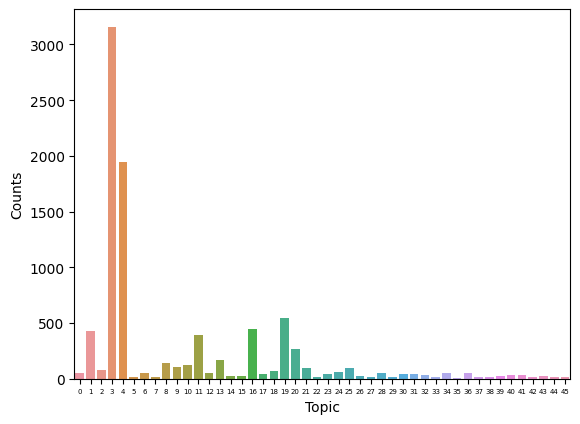

In [59]:
sns.barplot(topic, x = 'Topic', y = 'Counts')
plt.xticks(fontsize = 5)
plt.show()

In [60]:
word_index = imdb.get_word_index() # 단어-정수가 매칭된 dict 객체 호출
reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])
decoded_review = " ".join([reverse_word_index.get(i-3,'?') for i in train_data[0]])
'''
index 0,1,2는
'패딩', '문서 시작', '사전에 없음'
을 위해 예약 되어 있어 3개를 제외하고 시작함
'''
decoded_review

"? ? ? to just br loved and you i've set and broke many was friends seems him see of how and with movies a with know that him see people film guess are of if the some to okay from without old a though a into in that film thing in that of if is scarecrow outside days a found a looks in that film these about in that was to thought 100 him see good he without be all man a character that as it"

In [61]:
# list to tensor 2
def vectorize_sequences(seqs, dimension = 10000):
  results = np.zeros((len(seqs),dimension)) # (samples, dimension) 사이즈의 0 행렬 생성
  for i, seq in enumerate(seqs):
    for j in seq:
      results[i,j] = 1. # 특정 인덱스의 위치를 1로 지정
  return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [62]:
def to_one_hot(labels, dimension = 46):
  results = np.zeros((len(labels), dimension))
  for i , label in enumerate(labels):
    results[i, label] = 1.
  return results

y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [63]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [64]:
y_train[0].shape

(46,)

### 4.2.3 모델 구성

In [65]:
def Model2():
  seq = keras.Input(shape = (x_train.shape[1]))
  x = layers.Dense(64, activation = 'relu')(seq)
  x = layers.Dense(64, activation = 'relu')(x)
  x = layers.Dense(46, activation = 'softmax')(x)

  return keras.Model(inputs = seq, outputs = x)

In [66]:
model = Model2()
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

### 4.2.4 훈련 검증

validation length = 1000

In [67]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

x_val.shape, partial_x_train.shape

((1000, 10000), (7982, 10000))

In [68]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs =20,
                    batch_size = 512,
                    validation_data = [x_val, y_val])

Epoch 1/20
16/16 [==============================] - 2s 66ms/step - loss: 2.8640 - accuracy: 0.5000 - val_loss: 1.9793 - val_accuracy: 0.6090
Epoch 2/20
16/16 [==============================] - 1s 52ms/step - loss: 1.6401 - accuracy: 0.6706 - val_loss: 1.4429 - val_accuracy: 0.6670
Epoch 3/20
16/16 [==============================] - 1s 52ms/step - loss: 1.2409 - accuracy: 0.7348 - val_loss: 1.2189 - val_accuracy: 0.7330
Epoch 4/20
16/16 [==============================] - 1s 51ms/step - loss: 1.0140 - accuracy: 0.7788 - val_loss: 1.1010 - val_accuracy: 0.7590
Epoch 5/20
16/16 [==============================] - 1s 49ms/step - loss: 0.8435 - accuracy: 0.8182 - val_loss: 1.0342 - val_accuracy: 0.7650
Epoch 6/20
16/16 [==============================] - 1s 49ms/step - loss: 0.7088 - accuracy: 0.8477 - val_loss: 0.9641 - val_accuracy: 0.7930
Epoch 7/20
16/16 [==============================] - 1s 49ms/step - loss: 0.5980 - accuracy: 0.8716 - val_loss: 0.9293 - val_accuracy: 0.7960
Epoch 8/20
16

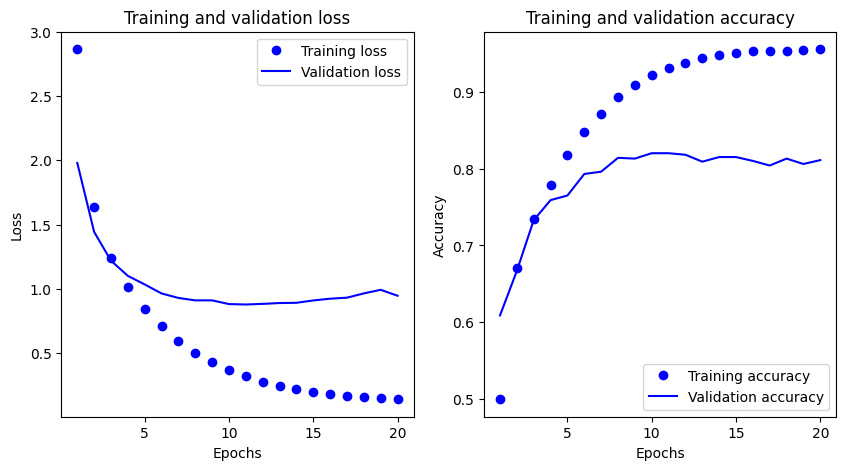

In [69]:
show_log(history)

In [70]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 4ms/step - loss: 1.0490 - accuracy: 0.7912


[1.0489646196365356, 0.7911843061447144]

In [71]:
model = Model2()
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs =9,
                    batch_size = 512,
                    validation_data = [x_val, y_val])

Epoch 1/9
16/16 [==============================] - 2s 65ms/step - loss: 2.7355 - accuracy: 0.4927 - val_loss: 1.8320 - val_accuracy: 0.5800
Epoch 2/9
16/16 [==============================] - 1s 49ms/step - loss: 1.5419 - accuracy: 0.6625 - val_loss: 1.3990 - val_accuracy: 0.6900
Epoch 3/9
16/16 [==============================] - 1s 52ms/step - loss: 1.1731 - accuracy: 0.7464 - val_loss: 1.2188 - val_accuracy: 0.7230
Epoch 4/9
16/16 [==============================] - 1s 49ms/step - loss: 0.9632 - accuracy: 0.7924 - val_loss: 1.0836 - val_accuracy: 0.7650
Epoch 5/9
16/16 [==============================] - 1s 49ms/step - loss: 0.7979 - accuracy: 0.8324 - val_loss: 1.0213 - val_accuracy: 0.7810
Epoch 6/9
16/16 [==============================] - 1s 51ms/step - loss: 0.6689 - accuracy: 0.8552 - val_loss: 0.9592 - val_accuracy: 0.8020
Epoch 7/9
16/16 [==============================] - 1s 51ms/step - loss: 0.5539 - accuracy: 0.8822 - val_loss: 0.9186 - val_accuracy: 0.8070
Epoch 8/9
16/16 [===

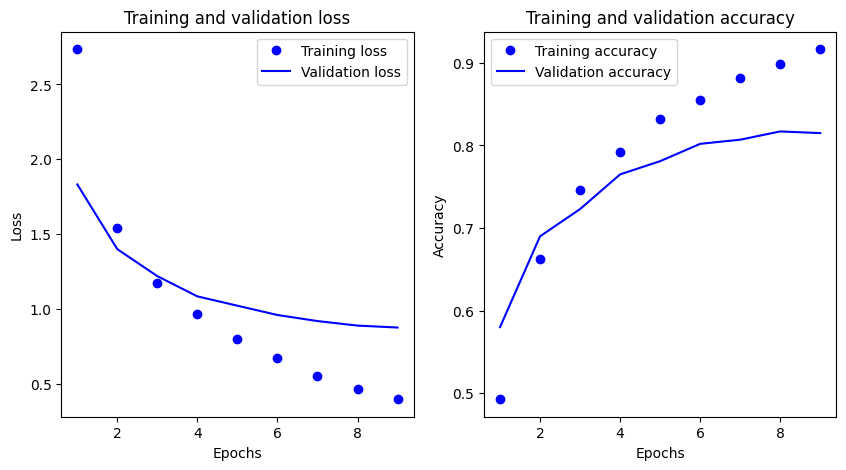

In [72]:
show_log(history)

In [73]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 3ms/step - loss: 0.9348 - accuracy: 0.7934


[0.934842586517334, 0.7934104800224304]

랜덤 분류기를 사용하여 예측했을 떄 성능 확인

In [74]:
import copy

test_labels_copy = copy.copy(test_labels)

In [75]:
np.random.shuffle(test_labels_copy)
hist_array = np.array(test_labels) == np.array(test_labels_copy)
hist_array.mean()

0.1918967052537845

### 4.2.5 새로운 데이터에 대해 예측하기

In [76]:
predictions = model.predict(x_test)
predictions[0]

71/71 [==============================] - 0s 4ms/step


array([1.03811444e-05, 2.57685111e-04, 2.05034985e-06, 9.43602383e-01,
       4.89054732e-02, 1.14696186e-05, 1.45525946e-05, 1.00015750e-05,
       3.01843486e-03, 7.94114385e-06, 1.73330463e-05, 6.71311049e-04,
       1.45086597e-04, 2.02122261e-04, 1.20406447e-04, 1.95158282e-06,
       7.34801797e-05, 4.92328809e-06, 1.03583356e-04, 4.48137114e-04,
       4.31629625e-04, 1.65473000e-04, 2.84854082e-06, 3.09180396e-05,
       2.02205342e-06, 1.05052777e-05, 3.41871828e-06, 3.81147106e-06,
       4.68472317e-05, 9.94485104e-04, 4.43704848e-05, 9.52078790e-06,
       2.32480033e-06, 1.87154164e-05, 9.45988213e-05, 1.11918889e-05,
       2.03731222e-04, 3.20409526e-05, 4.04084130e-05, 6.26891779e-05,
       2.97665847e-05, 1.62678352e-05, 1.26855539e-07, 4.19340395e-05,
       6.47046909e-05, 6.98655322e-06], dtype=float32)

In [77]:
predictions[0].shape

(46,)

In [78]:
np.sum(predictions[0])

1.0000001

In [79]:
np.argmax(predictions[0])

3

### 4.2.6 레이블과 손실을 다루는 다른 방법

추가실험: Sparse_categorical_crossentropy 사용

target이 정수인 경우 tf 안에서 자동으로 one-hot encoding 해주는 손실함수

In [80]:
val_labels = train_labels[:1000]
partial_train_labels = train_labels[1000:]

In [81]:
len(val_labels),len(partial_train_labels)

(1000, 7982)

In [82]:
model = Model2()
model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [83]:
history2 = model.fit(partial_x_train,
                    partial_train_labels,
                    epochs =20,
                    batch_size = 512,
                    validation_data = [x_val, val_labels])

Epoch 1/20
16/16 [==============================] - 2s 64ms/step - loss: 2.8833 - accuracy: 0.4845 - val_loss: 2.0182 - val_accuracy: 0.6080
Epoch 2/20
16/16 [==============================] - 1s 52ms/step - loss: 1.6794 - accuracy: 0.6536 - val_loss: 1.4699 - val_accuracy: 0.6750
Epoch 3/20
16/16 [==============================] - 1s 50ms/step - loss: 1.2674 - accuracy: 0.7251 - val_loss: 1.2370 - val_accuracy: 0.7340
Epoch 4/20
16/16 [==============================] - 1s 51ms/step - loss: 1.0264 - accuracy: 0.7801 - val_loss: 1.1114 - val_accuracy: 0.7490
Epoch 5/20
16/16 [==============================] - 1s 91ms/step - loss: 0.8484 - accuracy: 0.8181 - val_loss: 1.0297 - val_accuracy: 0.7780
Epoch 6/20
16/16 [==============================] - 1s 81ms/step - loss: 0.7097 - accuracy: 0.8505 - val_loss: 0.9748 - val_accuracy: 0.7870
Epoch 7/20
16/16 [==============================] - 1s 49ms/step - loss: 0.5984 - accuracy: 0.8723 - val_loss: 0.9382 - val_accuracy: 0.8020
Epoch 8/20
16

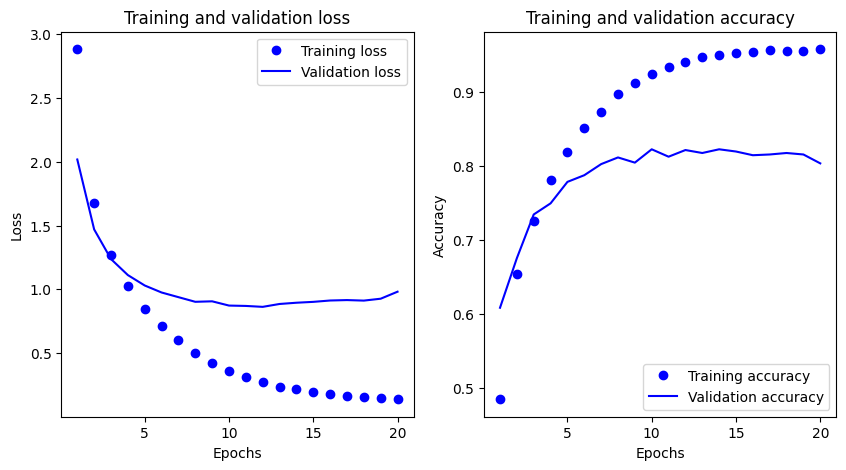

In [84]:
show_log(history2)

In [85]:
model = Model2()
model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history3 = model.fit(partial_x_train,
                    partial_train_labels,
                    epochs = 9,
                    batch_size = 512,
                    validation_data = [x_val, val_labels])

Epoch 1/9
16/16 [==============================] - 1s 65ms/step - loss: 2.8080 - accuracy: 0.4717 - val_loss: 1.8788 - val_accuracy: 0.6210
Epoch 2/9
16/16 [==============================] - 1s 50ms/step - loss: 1.5751 - accuracy: 0.6760 - val_loss: 1.4009 - val_accuracy: 0.6850
Epoch 3/9
16/16 [==============================] - 1s 50ms/step - loss: 1.2034 - accuracy: 0.7370 - val_loss: 1.2124 - val_accuracy: 0.7410
Epoch 4/9
16/16 [==============================] - 1s 47ms/step - loss: 0.9818 - accuracy: 0.7835 - val_loss: 1.0845 - val_accuracy: 0.7560
Epoch 5/9
16/16 [==============================] - 1s 49ms/step - loss: 0.8107 - accuracy: 0.8230 - val_loss: 1.0035 - val_accuracy: 0.7760
Epoch 6/9
16/16 [==============================] - 1s 48ms/step - loss: 0.6707 - accuracy: 0.8543 - val_loss: 0.9556 - val_accuracy: 0.8070
Epoch 7/9
16/16 [==============================] - 1s 49ms/step - loss: 0.5577 - accuracy: 0.8829 - val_loss: 0.9092 - val_accuracy: 0.8080
Epoch 8/9
16/16 [===

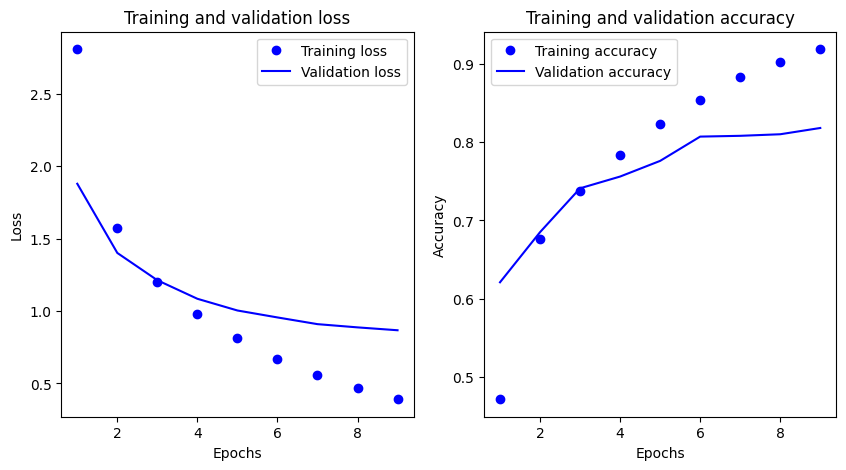

In [86]:
show_log(history3)

In [87]:
results = model.evaluate(x_test, test_labels)

71/71 [==============================] - 0s 3ms/step - loss: 0.9513 - accuracy: 0.7854


In [88]:
predictions = model.predict(x_test)
predictions

71/71 [==============================] - 0s 3ms/step


array([[5.2501837e-05, 3.2530780e-04, 3.2209016e-05, ..., 4.3424803e-05,
        3.0348374e-05, 1.9872348e-06],
       [1.4526746e-03, 1.8917350e-02, 5.4691406e-03, ..., 2.9638052e-04,
        5.9410254e-06, 3.1912609e-04],
       [1.5317793e-02, 8.4644139e-01, 3.8209502e-03, ..., 1.7361091e-04,
        6.2231661e-04, 1.0995892e-04],
       ...,
       [2.1009674e-04, 4.1593920e-04, 3.2840829e-04, ..., 1.8077476e-04,
        4.7273050e-05, 8.5736665e-06],
       [2.6601262e-03, 3.8125414e-02, 3.8181066e-03, ..., 2.3916170e-04,
        4.4204388e-04, 7.0053386e-05],
       [2.4149861e-04, 3.6324757e-01, 9.0991082e-03, ..., 2.6827652e-04,
        1.7667237e-04, 3.1831642e-04]], dtype=float32)

In [89]:
predictions[0].shape

(46,)

In [90]:
np.sum(predictions[0])

0.9999999

In [91]:
np.argmax(predictions[0])

3

### 4.2.7 충분히 큰 중간층을 두어야 하는 이유



Epoch 1/20
63/63 [==============================] - 2s 20ms/step - loss: 3.2867 - accuracy: 0.0535 - val_loss: 2.8636 - val_accuracy: 0.0580
Epoch 2/20
63/63 [==============================] - 1s 16ms/step - loss: 2.4007 - accuracy: 0.3213 - val_loss: 2.0351 - val_accuracy: 0.3840
Epoch 3/20
63/63 [==============================] - 1s 16ms/step - loss: 1.8098 - accuracy: 0.4222 - val_loss: 1.6838 - val_accuracy: 0.5640
Epoch 4/20
63/63 [==============================] - 1s 18ms/step - loss: 1.5237 - accuracy: 0.5978 - val_loss: 1.5227 - val_accuracy: 0.5910
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 1.3546 - accuracy: 0.6208 - val_loss: 1.4320 - val_accuracy: 0.6260
Epoch 6/20
63/63 [==============================] - 1s 21ms/step - loss: 1.2377 - accuracy: 0.6488 - val_loss: 1.4022 - val_accuracy: 0.6360
Epoch 7/20
63/63 [==============================] - 2s 27ms/step - loss: 1.1490 - accuracy: 0.6695 - val_loss: 1.3392 - val_accuracy: 0.6540
Epoch 8/20
63

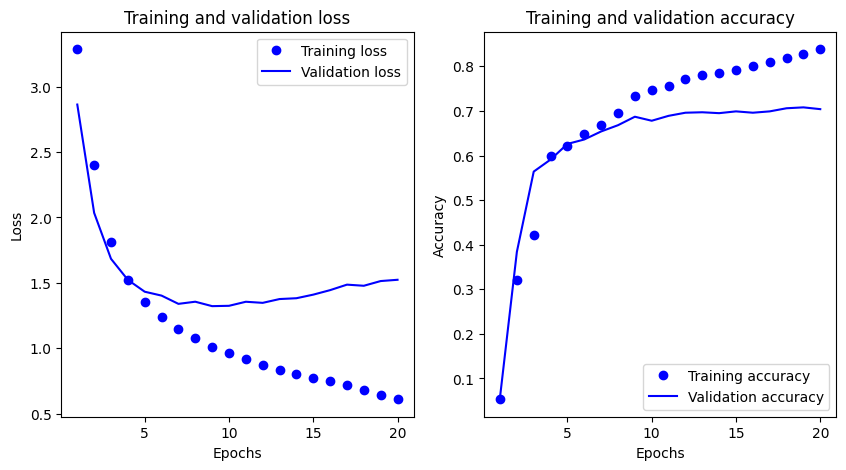

In [92]:
def Model3():
  seq = keras.Input(shape = (x_train.shape[1]))
  x = layers.Dense(64, activation = 'relu')(seq)
  x = layers.Dense(4, activation = 'relu')(x)
  x = layers.Dense(46, activation = 'softmax')(x)

  return keras.Model(inputs = seq, outputs = x)

model = Model3()
model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(partial_x_train,
                    partial_train_labels,
                    epochs = 20,
                    batch_size = 128,
                    validation_data = [x_val, val_labels])

show_log(history)

In [93]:
model.evaluate(x_test, test_labels)

71/71 [==============================] - 0s 3ms/step - loss: 1.7303 - accuracy: 0.6790


[1.7302953004837036, 0.6789848804473877]

9% 가량 성능 감소 확인

**데이터의 범주보다 적은 유닛을 사용하지 말 것**

### 4.2.8 추가 실험

1. 더 크거나 작은 층 사용 32 유닛, 128 유닛등
2. 1개 혹은 3개의 layer를 더 사용할 것

## 4.3 주택 가격 예측 : 회귀 문제

회귀 : 연속적인 값을 예측

> note : logistic regression은 `분류`, 5장에 예시 존재

1970년 중반 보스턴 외곽 지역의 범죄율, 제방세율의 데이터를 활용, 주택가격의 중간 값을 예측

각 특성들은 스케일이 다름

In [147]:
from tensorflow.keras.datasets import boston_housing


(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [148]:
train_data.shape

(404, 13)

In [149]:
test_data.shape

(102, 13)

In [150]:
train_data

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
        3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, ..., 1.47000e+01,
        3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.75520e+02, 3.26000e+00],
       ...,
       [3.46600e-02, 3.50000e+01, 6.06000e+00, ..., 1.69000e+01,
        3.62250e+02, 7.83000e+00],
       [2.14918e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        2.61950e+02, 1.57900e+01],
       [1.43900e-02, 6.00000e+01, 2.93000e+00, ..., 1.56000e+01,
        3.76700e+02, 4.38000e+00]])

In [151]:
train_targets[:10] # 천달러 단위

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

### 4.3.2 데이터 준비

`전역 최소 점을 찾아가는 경사 하강법의 경로가 스케일에 영향을 받기 때문에` 다른 스케일의 데이터가 들어있어 이에 대한 전처리가 되어야함

정규화를 통하여 특성의 중앙이 0 근처에 맞추어 지고 표준 편차가 1이 됨


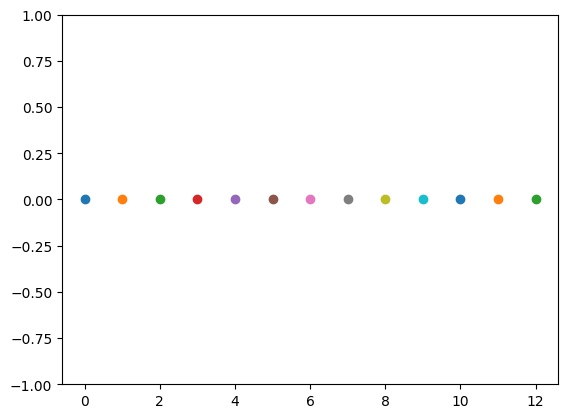

In [152]:
mean = train_data.mean(axis = 0)
train_data -= mean
for i, x in enumerate(train_data.mean(axis = 0)):
  # print(i,x)
  plt.scatter(i,x)
  plt.ylim([-1,1])

In [153]:
std = train_data.std(axis = 0)
train_data /= std

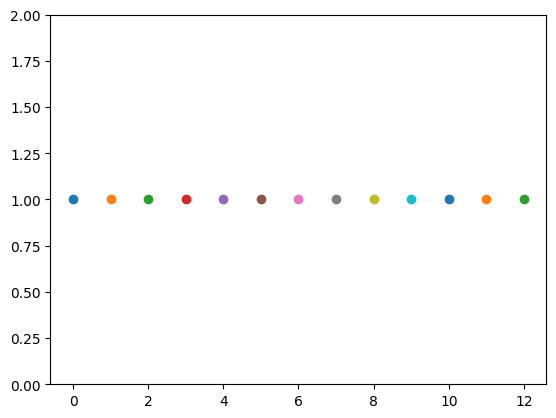

In [154]:
for i, x in enumerate(train_data.std(axis = 0)):
  # print(i,x)
  plt.scatter(i,x)
  plt.ylim([0,2])

모델은 train data에 대한 정규화된 데이터 환경에서 학습되기 때문에 test set 또한 `train`의 평균과 표준편차를 사용하여 정규화를 진행하여야 함

**test set 자체에서 정규화가 이루어지면 값에 대한 기준이 달라지기 때문에 예측에 문제가 생김**

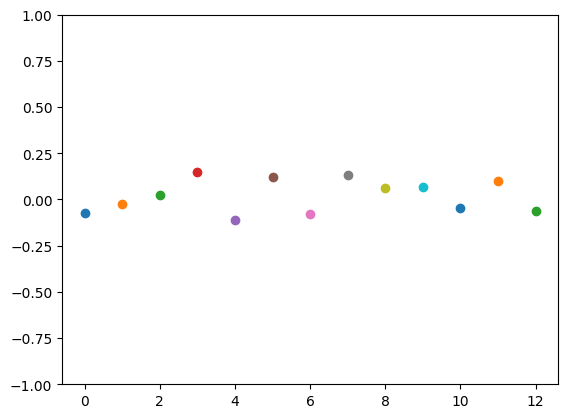

In [155]:
test_data -= mean
test_data /= std

for i, x in enumerate(test_data.mean(axis = 0)):
  # print(i,x)
  plt.scatter(i,x)
  plt.ylim([-1,1])

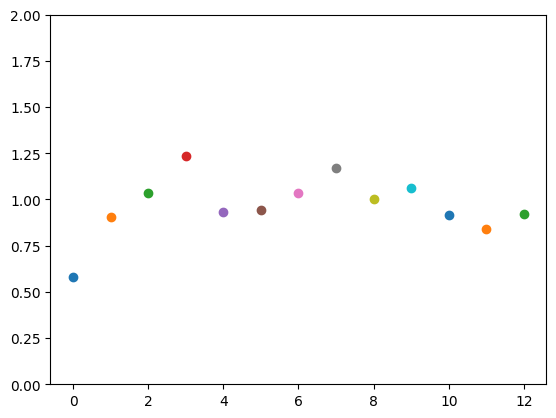

In [158]:
for i, x in enumerate(test_data.std(axis = 0)):
  # print(i,x)
  plt.scatter(i,x)
  plt.ylim([0,2])

### 4.3.3 모델 구성

샘플이 작은 것은 과대적합이 일어나기 쉬움

작은 모델을 사용하는 것을 권장함

In [130]:
def build_model():
  features = keras.Input(shape = (train_data.shape[1],))
  x = layers.Dense(64, activation = 'relu')(features)
  x = layers.Dense(64, activation = 'relu')(x)
  x = layers.Dense(1)(x)

  model = keras.Model(inputs = features, outputs = x)
  model.compile(optimizer = 'rmsprop',
                loss = 'mse',
                metrics = ["mae"])

  return model

회귀 문제에서는 마지막 층을 하나의 유닛만을 가지고 활성화함수를 사용하지 않는다. (선형층)

mae는 차이의 절대값으로 현재 문제에서 0.5의 오차를 보인다면 500달러 정도의 차이를 보인다는 의미임

### 4.3.4 K-겹 검증을 사용한 훈련 검증

데이터가 적는 경우에는 validation data의 수도 적어질 수 밖에 없음

나눠지는 경우에 따라 검증 metrics가 차이가 나기 때문에 `k-fold cross-validation`을 사용

일반적으로 5개로 분할하여 CV(cross-validation)을 진행


![cv](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

<center>[이미지출처:scikit-learn documentation]


train set과 validation set이 다른 구성인 경우, validation set 도 train set의 전처리과정을 따라야 함

`Pipeline class를 이용`하여 CV과정에 전처리를 포함할 수 있음


In [123]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100

all_scores = []

for i in range(k):
  print(f"Processing {i}th fold...")
  val_data = train_data[i*num_val_samples : (i+1) * num_val_samples]
  val_targets = train_targets[i*num_val_samples : (i+1) * num_val_samples]

  partial_train_data = np.concatenate(
      [
        train_data[:i*num_val_samples:],
       train_data[(i+1)*num_val_samples:]
       ],
      axis = 0
  )
  partial_train_targets = np.concatenate(
      [
        train_targets[:i*num_val_samples:],
       train_targets[(i+1)*num_val_samples:]
       ],
      axis = 0
  )

  model = build_model()
  model.fit(partial_train_data,
            partial_train_targets,
            epochs = num_epochs,
            batch_size = 16,
            verbose = 0)
  '''
  0 = silent,
  1 = progress bar,
  2 = one line per epoch.
  '''

  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
  all_scores.append(val_mae)

all_scores

Processing 0th fold...
Processing 1th fold...
Processing 2th fold...
Processing 3th fold...


[2.004044532775879, 2.464768409729004, 2.4891648292541504, 2.538238525390625]

In [125]:
np.mean(all_scores) # 평균 예측값을 이용하면 약 2400달러 쯤 차이날 수 있음

2.3740540742874146

In [132]:
num_epochs = 500

all_mae_histories = []

for i in range(k):
  print(f"Processing {i}th fold...")
  val_data = train_data[i*num_val_samples : (i+1) * num_val_samples]
  val_targets = train_targets[i*num_val_samples : (i+1) * num_val_samples]

  partial_train_data = np.concatenate(
      [
        train_data[:i*num_val_samples:],
       train_data[(i+1)*num_val_samples:]
       ],
      axis = 0
  )
  partial_train_targets = np.concatenate(
      [
        train_targets[:i*num_val_samples:],
       train_targets[(i+1)*num_val_samples:]
       ],
      axis = 0
  )

  model = build_model()
  history = model.fit(partial_train_data,
            partial_train_targets,
            epochs = num_epochs,
            batch_size = 16,
            validation_data = (val_data, val_targets),
            verbose = 0)
  '''
  0 = silent,
  1 = progress bar,
  2 = one line per epoch.
  '''
  all_mae_histories.append(history.history['val_mae'])


Processing 0th fold...
Processing 1th fold...
Processing 2th fold...
Processing 3th fold...


In [134]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

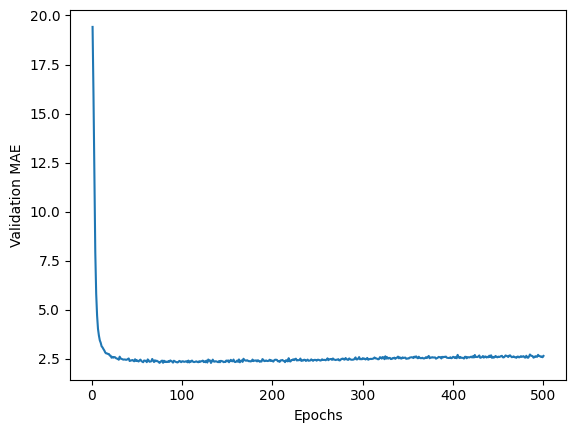

In [135]:
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

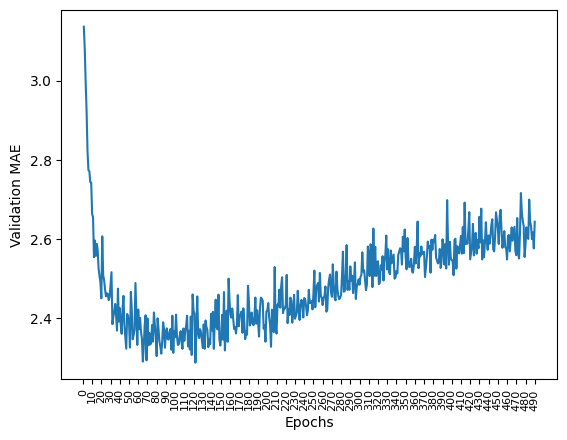

In [139]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history)+1), truncated_mae_history)
plt.xticks(range(0,500,10), fontsize = 8, rotation = 90)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
model = build_model()
model.fit(train_data,
          train_targets,
          epochs = 130,
          batch_size = 16,
          verbose = 0)


In [159]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 15.7741 - mae: 2.4847


In [160]:
test_mae_score

2.4847373962402344

### 4.3.5 새로운 데이터에 대해 예측하기

* predict 사용

In [161]:
predictions = model.predict(test_data)
predictions[0]

4/4 [==============================] - 0s 4ms/step


array([9.050262], dtype=float32)

In [162]:
test_targets[0]

7.2